In [3]:
!pip install pymongo
!pip install catboost

In [109]:
from functools import reduce
import copy
from sklearn.preprocessing import StandardScaler
import pandas as pd
from tqdm import tqdm
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import pickle
pd.options.mode.chained_assignment = None
import numpy as np
import os

Проверим нашу модель на всех студентах, которые пользуются гитлабом для ведения проекта

In [1]:
connection = {'host': '***',
              'username': '***',
              'password': '***'}


In [45]:
#класс для подключения к базе данных
from pymongo import MongoClient

class FootprintClient:
    
    def __init__(self, connection: dict):
        
        self.host = connection['host']
        self.username = connection['username']
        self.password = connection['password']
    
    def gitlab_connect(self, db):

        client = MongoClient(self.host,
                          username=self.username,
                          password=self.password)
        conn = client[db]
        return conn


In [46]:
#класс для создания датасета с признаками по гитлабу
class GitlabPrepocessor(FootprintClient):
    
    def __init__(self, connection):
        super().__init__(connection)
        self.gitlab = self._query_gitlab_projects()
    def _query_gitlab_projects(self, filtr={}, query={}):
        db = self.gitlab_connect('app')
        collection = db.git
        return list(collection.find(filtr, query))
    
    def get_feature_dataset(self):
        df = pd.DataFrame(self.gitlab)
        columns=['id', 'namespaceName', 
                'activeMonthCount', 
                'additionsSum', 'deletionsSum']
        df_features = pd.DataFrame(columns=columns)
        
        for i in tqdm(range(len(df))):
            if pd.json_normalize(df.iloc[i]['projects']).shape[0] == 0 or pd.json_normalize(df.iloc[i]['projects']).shape[
                1] == 0:
                continue
            id = df.iloc[i]['id']
            person_projects = pd.json_normalize(df.iloc[i]['projects'])[['namespace.name', 'commits']]
            person_projects = person_projects[~person_projects['namespace.name'].isnull()]
            person_projects = person_projects[person_projects['namespace.name'].apply(
                    lambda x: x[0].isdigit()
                              and x[-1].isalpha())]
            for i in range(person_projects.shape[0]):
                commits_df = pd.json_normalize(person_projects.iloc[i]['commits'])
                if commits_df.shape[0] == 0:
                    continue
                commits_df['committed_date'] = pd.to_datetime(commits_df['committed_date'], unit='ms')
                namespace_name = person_projects.iloc[i]['namespace.name']
                # добавление в ячейку датафрейма множества, а не сразу длины, для дальнейшего его расширения
                active_month_count = set(commits_df['committed_date'].map(lambda x: 100 * x.year + x.month))
                additions_sum = commits_df['stats.additions'].sum()
                deletions_sum = commits_df['stats.deletions'].sum()

                persons_id = df_features[df_features['id'] == id]['id']

                if (len(active_month_count) + additions_sum + deletions_sum != 0) and (
                        namespace_name not in persons_id.unique()):
                    new_person = {'id': id,
                                  'namespaceName': namespace_name,
                                  'activeMonthCount': active_month_count,
                                  'additionsSum': additions_sum,
                                  'deletionsSum': deletions_sum}
                    df_features = pd.concat([df_features, pd.DataFrame([new_person.values()], columns=df_features.columns)], ignore_index=True)

                elif (len(active_month_count) + additions_sum + deletions_sum != 0) and (
                        namespace_name in persons_id.unique()):
                    # если уже встречалось - дополняем, а не добавляем новый, а для множеств ищем объединения
                    df_features.loc[
                        df_features[(df_features['id'] == id) & (df_features['namespaceName'] == namespace_name)].index[
                            0], 'activeMonthCount'] |= active_month_count
                    df_features.loc[
                        df_features[(df_features['id'] == id) & (df_features['namespaceName'] == namespace_name)].index[
                            0], 'additionsSum'] += additions_sum
                    df_features.loc[
                        df_features[(df_features['id'] == id) & (df_features['namespaceName'] == namespace_name)].index[
                            0], 'deletionsSum'] += deletions_sum
        df_features['activeMonthCount'] = df_features['activeMonthCount'].apply(lambda x: len(x))        
        df_features = df_features.astype({
                    'activeMonthCount': 'int32',
                    'additionsSum': 'int32',
                    'deletionsSum': 'int32'})
        return df_features


In [11]:
#класс для подсчета проектного рейтинга
class ProjectRateCalculator:
    
    def __init__(self, df, model_path, scaler_path):
        self.id = df['id']
        self.scaler = self._load_scaler(scaler_path)
        self.df = self.scaler.transform(df.drop(['id', 'namespaceName'], axis=1))
        self.model = self._load_model(model_path)
    def _load_model(self, model_path):
        # with open(model_path, 'rb') as f:
        #     model = pickle.load(f)
        # return model
        model = CatBoostRegressor()
        return model.load_model(model_path)
    def _load_scaler(self, scaler_path):
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
        return scaler

    def calculate_project_rate(self):

        df_project_rate = pd.DataFrame(np.clip(self.model.predict(self.df), 0, 10), columns=['rate'])
        df_project_rate.dropna(inplace=True)
        df_project_rate.reset_index(drop=True, inplace=True)
        df_project_rate['percentile_rate'] = ((df_project_rate['rate'].rank(method='max', pct=True)*100)-100).abs()
        df_project_rate['percentile_rank'] = (df_project_rate['rate'].rank(method='max')-len(df_project_rate)).abs()+1
        return df_project_rate




In [8]:
gp = GitlabPrepocessor(connection)

In [9]:
df = gp.get_feature_dataset()

100%|██████████| 3402/3402 [01:01<00:00, 55.45it/s] 


In [47]:
df

,id,namespaceName,activeMonthCount,additionsSum,deletionsSum
0,160,19290 Разработка мобильного приложения для инт...,2,13761,6139
1,153,19121 Разработка алгоритмов распознавания текс...,1,305,101
2,153,19121 Разработка алгоритмов распознавания текс...,1,305,101
3,152,19121 Разработка алгоритмов распознавания текс...,1,37,0
4,152,19121 Разработка алгоритмов распознавания текс...,1,37,0
...,...,...,...,...,...
1639,3431,1351 Построение системы оценки качества деятел...,1,92,0
1640,3453,1327 Редукция численных методов для построения...,1,0,0
1641,3456,1356 Exo world Казуальная Telegram игра,1,74,67
1642,3531,1246 Bear head studio Маркетплейс ассетов,1,40,0


In [13]:
model_path = '/content/drive/MyDrive/model/rating_model'
scaler_path = '/content/drive/MyDrive/model/scaler.pkl'

pr = ProjectRateCalculator(df, model_path, scaler_path)

1105 1644


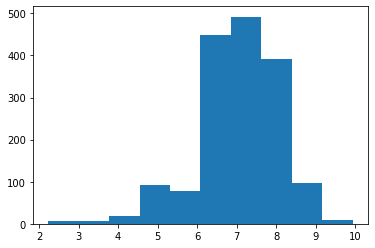

In [110]:
print(np.unique(pr.calculate_project_rate()['rate']).shape[0], len(pr.id))

plt.hist(pr.calculate_project_rate()['rate']);

На графике выше изображена гистограмма распределения проектного рейтинга для всех студентов. Можем заметить, что результат мы получили, действительно, приемлемый. Проверим, смогла ли модель предсказывать оценки, которые похожи на оценки из генеральной совокупности оценок преподавателей. Для этого проведем сравнение двух средних, используя t-критерий



Загрузим оценки, проставленные преподавателями:

In [111]:
df_marks = pd.DataFrame(columns=['mark']) 
for table in os.listdir('/content/drive/MyDrive/bd_git/marks/'):
  with open('/content/drive/MyDrive/bd_git/marks/' + table) as f:
     df_marks = pd.concat([df_marks, pd.read_csv(f, sep=';')[['mark']]])


Проверим, присутствуют ли пропущенные значения

In [136]:
df_marks.isna().sum()

mark    5
dtype: int64

In [142]:
df_marks = df_marks.dropna().astype('int64')

In [151]:
real_mean = df_marks.mean()
real_std = df_marks.std()
real_n = len(df_marks)

In [153]:
pred_mean = pr.calculate_project_rate()['rate'].mean()
pred_std = pr.calculate_project_rate()['rate'].std()
pred_n = len(pr.calculate_project_rate()['rate'])

In [157]:
print('M1 = ' + str(real_mean.values[0]))
print('std1 = ' + str(real_std.values[0]))
print('n1 = ' + str(real_n))

M1 = 6.598194130925508
std1 = 2.2421128833044155
n1 = 886


In [159]:
print('M2 = ' + str(pred_mean))
print('std2 = ' + str(pred_std))
print('n2 = ' + str(pred_n))

M2 = 7.067936312370734
std2 = 0.997941500744526
n2 = 1644


Выдвенем две гипотезы:
- H0 - обе эти выборки были взяты из одной генеральной совокупности
- H1 - выборки были взяты из разных генеральных совокупностей 

Расчитаем t-критерий:

In [162]:
t = (pred_mean - real_mean) / np.sqrt(real_std ** 2 / real_n + pred_std ** 2 / pred_n)
t

mark    5.92777
dtype: float64

Расчитаем pvalue при полученном t-значении и количестве числа свобод n1 + n2 - 2 = 2528 \
Получили значение p-value < .00001 \
Делаем вывод, что простой градиентный бустинг, обученный на небольшом количестве данных, не смог приблизить рейтинг к оценкам из генеральной совокупности оценок, выставляемых проподавателями

Также проверим наше изнчальное положение: рейтинг коррелирует с каждым из признаков \


Для этого выдвеним две гипотезы:

 - H0 - различие между выборочным коэффициентом корреляции r и ρ = 0 незначимо 
 - H1 - различие между r и p=0 значимо, и следовательно, между переменными имеется существенная связь. 

In [163]:
from scipy.stats import spearmanr

In [164]:
print('additionsSum: ')
print("Corr: " + str(spearmanr(merge_df['additionsSum'], merge_df['rate'])[0]))
print("Pvalue: " + str(spearmanr(merge_df['additionsSum'], merge_df['rate'])[1]))

additionsSum: 
Corr: 0.38279826747296514
Pvalue: 1.6344361972058408e-58


In [165]:
print('additionsSum: ')
print("Corr: " + str(spearmanr(merge_df['deletionsSum'], merge_df['rate'])[0]))
print("Pvalue: " + str(spearmanr(merge_df['deletionsSum'], merge_df['rate'])[1]))

additionsSum: 
Corr: 0.4244265632970407
Pvalue: 7.020901649451318e-73


In [166]:
print('activeMonthCount: ')
print("Corr: " + str(spearmanr(merge_df['activeMonthCount'], merge_df['rate'])[0]))
print("Pvalue: " + str(spearmanr(merge_df['activeMonthCount'], merge_df['rate'])[1]))

activeMonthCount: 
Corr: 0.5047094851726524
Pvalue: 5.742198307789329e-107


Можем заметить, что, действительно, для каждого признака значение p_value < 0.05. Следовательно мы отклоняем нулевую гипотезу

Сопоставим значению рейтинга значения признаков и посмотрим на адекватность результатов


In [98]:
merge_df = pd.concat([df, pr.calculate_project_rate()], axis=1)
merge_df.sort_values(by='rate', ascending=False).head(40)

,id,namespaceName,activeMonthCount,additionsSum,deletionsSum,rate,percentile_rate,percentile_rank
1079,1596,234 Алгоритмы стеганографического встраивания ...,1,4649,1,9.940356,0.000000,1.0
739,723,430 Мобильное приложение для определения шрифтов,3,809413,415852,9.887175,0.060827,2.0
1443,2301,864 Разработка стенда удаленной для работы с о...,1,6,1,9.837175,0.121655,3.0
888,905,347 Система удаленной экспертной поддержки с и...,3,2076810,1304502,9.808284,0.182482,4.0
1252,1827,218 Разработка глоссария физических терминов д...,3,1437832,495340,9.808284,0.182482,4.0
171,46,313 Разработка программного обеспечения для из...,3,1383346,791624,9.808284,0.182482,4.0
623,487,464 Встраивание невидимых цифровых водяных зна...,3,1425156,561396,9.808284,0.182482,4.0
1328,1976,430 Мобильное приложение для определения шрифтов,3,4000633,239016,9.808284,0.182482,4.0
645,519,19001 Веб-архив арктических экспедиций AVA,2,1249211,0,9.287331,0.486618,9.0
1092,1410,19105 Клиентская часть системы контроля и упра...,5,313768,4845,9.284842,0.547445,10.0


Как можем заметить, модель периодически предсказывает слишком высокий рейтинг для низких значений признаков. Вероятнее всего это произошло из-за небольшого количества данных на обучении и поэтому, плоскость разделилась не совсем удачно. Помимо этого мы не сможем проинтерпретировать то, как модель принимает решение. Из-за этого придется отказаться от использования этой модели и сделать выбор в пользу линейной регрессии